# Core Plotting Functions

Here we want to introduce several visualization functions in stLearn.

Source: https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0


### Loading processed data

In [2]:
import pandas as pd
import stlearn as st
import pathlib as pathlib
import numpy as np
import random as random
import os as os

st.settings.set_figure_params(dpi=120)

seed = 0
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
sample_id = "V1_Breast_Cancer_Block_A_Section_1"

In [4]:
# Setup directory structure
project_root = pathlib.Path.cwd().parent
st.settings.datasetdir = project_root / "data"
annotation_path = project_root / "annotations"
cell_types_path = annotation_path / f"{sample_id}_cell_type_proportions.csv"
lr_summary_path = annotation_path / f"{sample_id}_lr_summary.csv"
lr_features_path = annotation_path / f"{sample_id}_lr_features.csv"
lr_data_path = annotation_path / f"{sample_id}_lr_data.h5ad"

In [5]:
# Read raw data
adata = st.datasets.visium_sge(sample_id=sample_id)
adata = st.convert_scanpy(adata)

In [6]:
# Adding the previous label transfer results
spot_mixtures = pd.read_csv(cell_types_path, index_col=0)
aligned_spot_mixtures = spot_mixtures.reindex(adata.obs_names, fill_value=0)
labels = aligned_spot_mixtures.idxmax(axis=1)
labels.name = "cell_type"
adata.obs['cell_type'] = labels
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.uns['cell_type'] = aligned_spot_mixtures

In [7]:
# Columns for LR summary/features
lr_uns_columns = ['lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type']
lr_obsm_columns = ["lr_scores", "p_vals", "p_adjs", "-log10(p_adjs)", "lr_sig_scores", "spot_neighbours"]

In [8]:
adata_processed = adata.copy()
st.pp.filter_genes(adata_processed, min_cells=3)
st.pp.normalize_total(adata_processed)
st.pp.log1p(adata_processed)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
st.em.run_pca(adata_processed, n_comps=50, random_state=0)
st.pp.neighbors(adata_processed, n_neighbors=25, use_rep='X_pca', random_state=0)
st.tl.clustering.louvain(adata_processed, resolution=1.15, random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


In [10]:
# Merge previous calculate LR run.
adata_processed = st.tl.cache.merge_h5ad_into_adata(adata_processed, lr_data_path)

Reading /Volumes/Data/work/stLearn-tutorials/annotations/V1_Breast_Cancer_Block_A_Section_1_lr_data.h5ad
Added obsm['-log10(p_adjs)'] with shape (3798, 1753)
Added obsm['lr_scores'] with shape (3798, 1753)
Added obsm['lr_sig_scores'] with shape (3798, 1753)
Added obsm['p_adjs'] with shape (3798, 1753)
Added obsm['p_vals'] with shape (3798, 1753)
Added obsm['spot_neighbours'] with shape (3798, 1)
Added uns['lr_summary']
Added uns['lrfeatures']
Added uns['per_lr_cci_cell_type']
Added uns['per_lr_cci_pvals_cell_type']
Added uns['per_lr_cci_raw_cell_type']


### Gene plot

Here is the standard plot for gene expression, we provide 2 options for single genes and multiple genes:

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type'
    obsm: 'spatial'

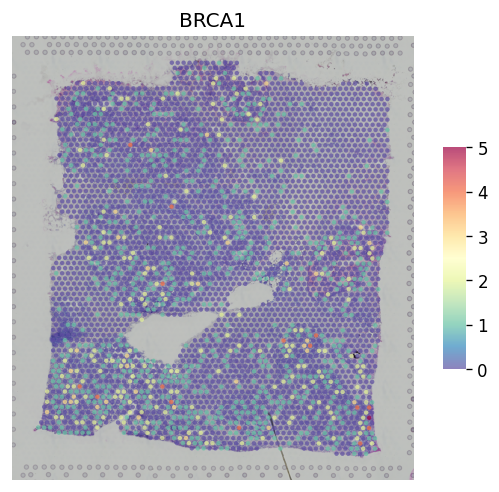

In [11]:
st.pl.gene_plot(adata, gene_symbols="BRCA1")

For multiple genes, you can combine multiple genes by `'CumSum'`cummulative sum or `'NaiveMean'`naive mean:

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type'
    obsm: 'spatial'

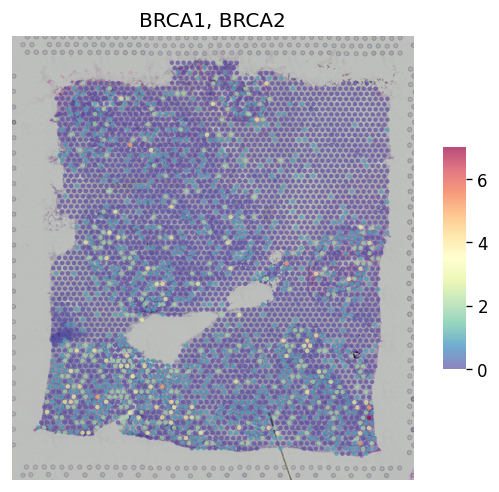

In [12]:
st.pl.gene_plot(adata, gene_symbols=["BRCA1", "BRCA2"], method="CumSum")

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type'
    obsm: 'spatial'

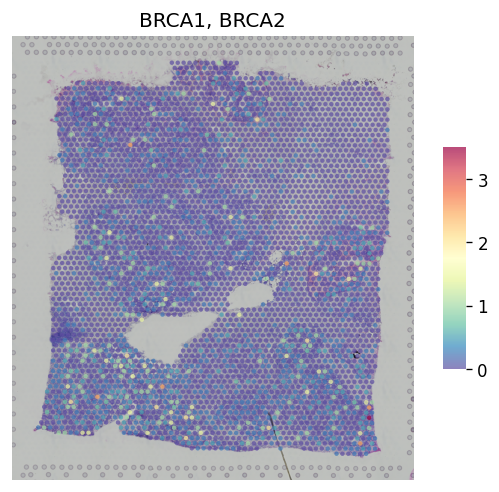

In [13]:
st.pl.gene_plot(adata, gene_symbols=["BRCA1", "BRCA2"], method="NaiveMean")

You also can plot genes with contour plot to see clearer about the distribution of genes:

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type'
    obsm: 'spatial'

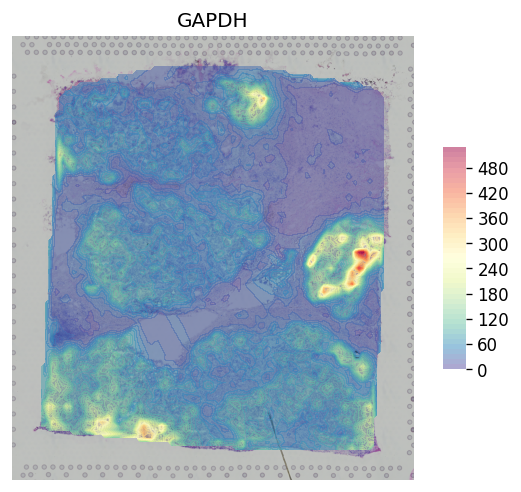

In [14]:
st.pl.gene_plot(adata, gene_symbols="GAPDH", contour=True, cell_alpha=0.5)

You can change the `step_size` to cut the range of display in contour

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'cell_type'
    obsm: 'spatial'

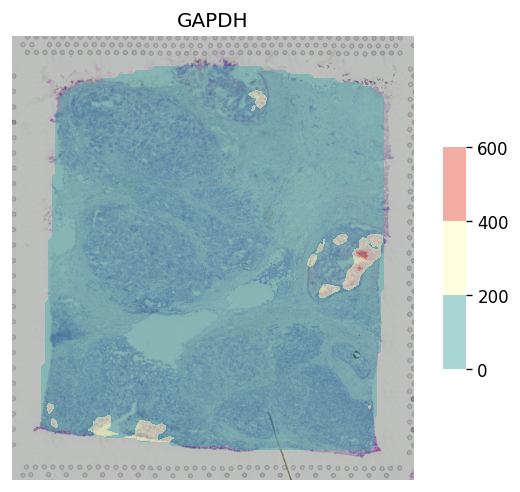

In [15]:
st.pl.gene_plot(adata, gene_symbols="GAPDH", contour=True, cell_alpha=0.5, step_size=200)

### Cluster plot

We provide different options for display clustering results. Several `show_*` options that user can control to display different parts of the figure:

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

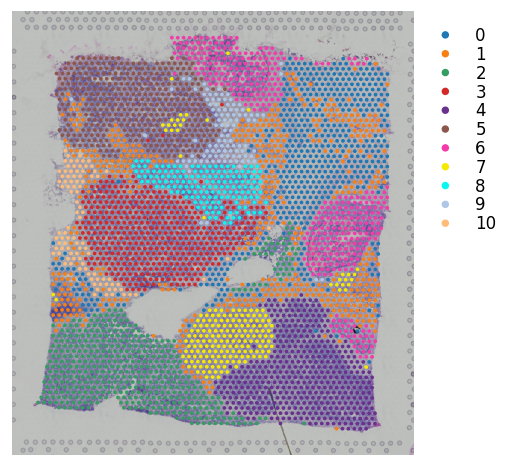

In [16]:
st.pl.cluster_plot(adata_processed, use_label="louvain")

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

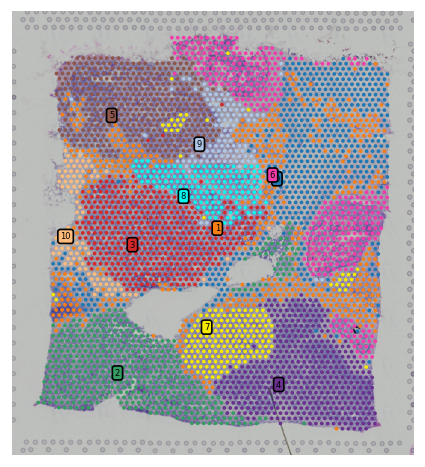

In [17]:
st.pl.cluster_plot(adata_processed, use_label="louvain", show_cluster_labels=True, show_color_bar=False)

### Subcluster plot

We also provide option to plot spatial subclusters based on the spatial location within a cluster.

You have two options here, display subclusters for multiple clusters using `show_subcluster` in `st.pl.cluster_plot` or use `st.pl.subcluster_plot` to display subclusters within a cluster but with different color.

In [18]:
# Generate subclusters with a distance of 50
st.spatial.clustering.localization(adata_processed, eps=50)

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain', 'sub_cluster_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors', 'louvain_index_dict'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

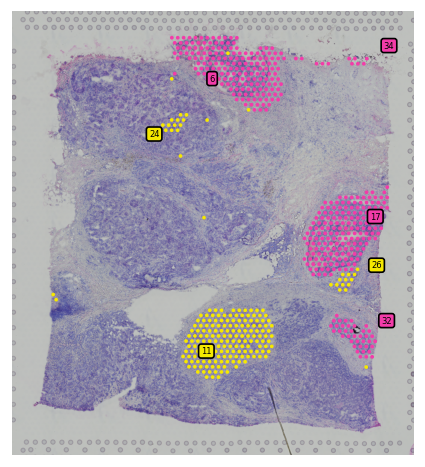

In [19]:
st.pl.cluster_plot(adata_processed, use_label="louvain", show_subcluster=True, show_color_bar=False,
                   list_clusters=["6", "7"])

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain', 'sub_cluster_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors', 'louvain_index_dict'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

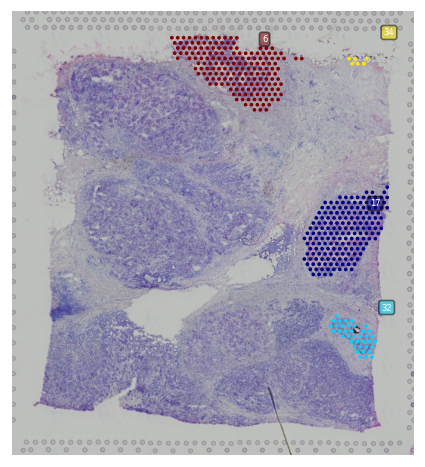

In [20]:
st.pl.subcluster_plot(adata_processed, use_label="louvain", cluster="6")

### Spatial trajectory plot

We provided `st.pl.trajectory.pseudotime_plot` to visualize PAGA graph that maps into spatial transcriptomics array.

In [21]:
adata_processed.raw = adata
adata_processed.uns["iroot"] = st.spatial.trajectory.set_root(adata_processed, use_label="louvain", cluster="6",
                                                              use_raw=True)
st.spatial.trajectory.pseudotime(adata_processed, eps=50, n_neighbors=30, use_rep="X_pca", use_label="louvain")

All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


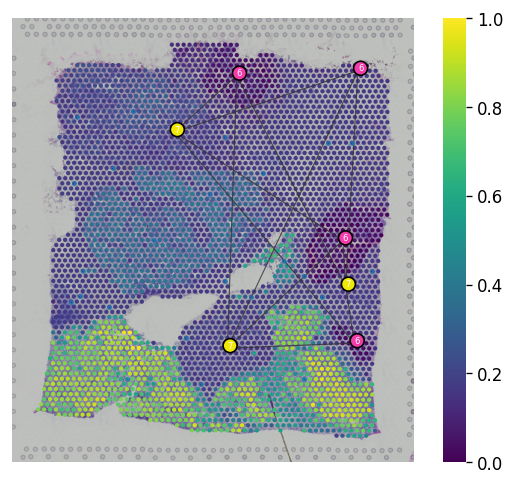

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors', 'louvain_index_dict', 'iroot', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [22]:
st.pl.trajectory.pseudotime_plot(adata_processed, use_label="louvain", pseudotime_key="dpt_pseudotime",
                                 list_clusters=["6", "7"], show_node=True)

In [23]:
st.spatial.trajectory.pseudotimespace_global(adata_processed, use_label="louvain", list_clusters=["6", "7"])

Start to construct the trajectory: 6 -> 7


AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors', 'louvain_index_dict', 'iroot', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

You can plot spatial trajectory analysis results with the node in each subcluster by `show_trajectories` and `show_node` parameters.

AnnData object with n_obs × n_vars = 3798 × 22240
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'cell_type', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'cell_type', 'log1p', 'pca', 'neighbors', 'louvain', 'lr_summary', 'lrfeatures', 'per_lr_cci_cell_type', 'per_lr_cci_pvals_cell_type', 'per_lr_cci_raw_cell_type', 'louvain_colors', 'louvain_index_dict', 'iroot', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph'
    obsm: 'spatial', 'X_pca', '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'spot_neighbours', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

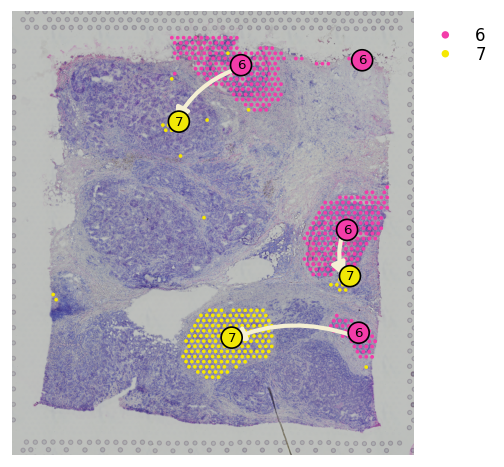

In [24]:
st.pl.cluster_plot(adata_processed, use_label="louvain", show_trajectories=True, show_color_bar=True,
                   list_clusters=["6", "7"], show_node=True)

### Ligand-receptor interaction plots

For the stLearn ligand-receptor cell-cell interaction analysis, you can display basic results for LRs using `st.pl.lr_result_plot`. For many more visualisations, please see the stLearn Cell-cell interaction analysis tutorial.

In [25]:
lr_pair_of_interest = 'COL1A2_ITGB1'

In [26]:
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
lrs

array(['A2M_LRP1', 'AANAT_MTNR1A', 'AANAT_MTNR1B', ..., 'ZP3_CHRNA7',
       'ZP3_EGFR', 'ZP3_MERTK'], dtype='<U18')

In [27]:
# Running the analysis
if (not all(key in adata_processed.uns for key in lr_uns_columns) or
    not all(key in adata_processed.obsm for key in lr_obsm_columns)):
    st.tl.cci.run(adata_processed, lrs,
                  min_spots=20,  # Filter out any LR pairs with no scores for less than min_spots
                  distance=100,  # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=500,   # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=4,      # Number of CPUs for parallel. If None, detects & use all available.
                  )

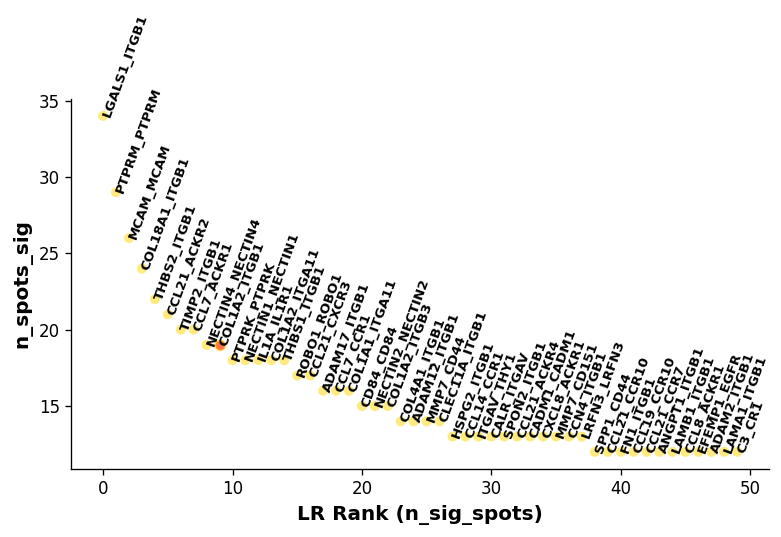

In [28]:
st.pl.lr_summary(adata_processed, highlight_lrs=[lr_pair_of_interest])

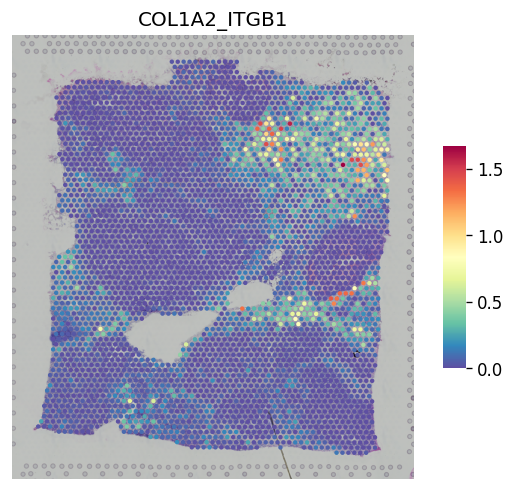

In [29]:
st.pl.lr_result_plot(adata_processed, lr_pair_of_interest, "-log10(p_adjs)")

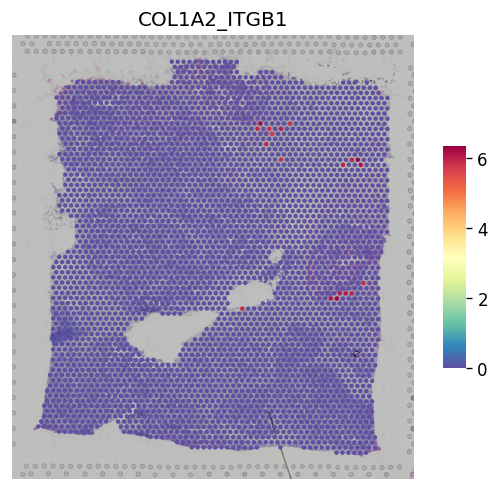

In [30]:
st.pl.lr_result_plot(adata_processed, lr_pair_of_interest, "lr_sig_scores")

### Cell-cell interaction plots
For the stLearn cell-cell interaction analysis, you can display the celltype-celltype interactions between cell types using `st.pl.lr_chord_plot`. 

In [31]:
if (not all(key in adata_processed.uns for key in lr_uns_columns) or
    not all(key in adata_processed.obsm for key in lr_obsm_columns)):
        st.tl.cci.run_cci(adata_processed,
                          'cell_type',  # Spot cell information either in data.obs or data.uns
                          min_spots=3,  # Minimum number of spots for LR to be tested.
                          spot_mixtures=True,  # If True will use the label transfer scores,
                          # so spots can have multiple cell types if score>cell_prop_cutoff
                          cell_prop_cutoff=0.2,  # Spot considered to have cell type if score>0.2
                          sig_spots=True,  # Only consider neighbourhoods of spots which had significant LR scores.
                          n_perms=100,  # Permutations of cell information to get background, recommend ~1000
                          n_cpus=4)

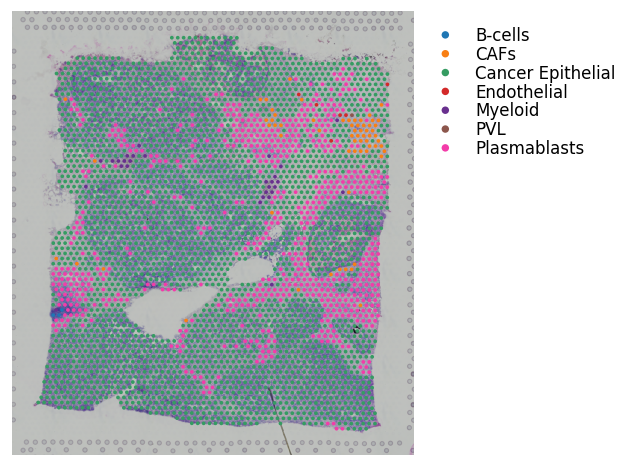

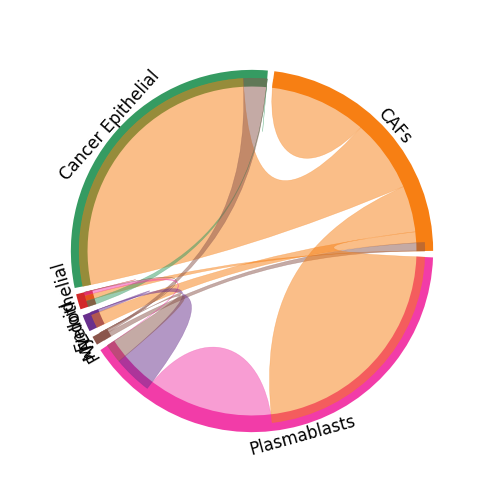

In [32]:
st.pl.cluster_plot(adata_processed, use_label='cell_type')
st.pl.lr_chord_plot(adata_processed, 'cell_type', lr_pair_of_interest, figsize=(4, 4))

In [33]:
# Uncomment to save new version.
# st.tl.cache.write_subset_h5ad(adata_processed, lr_data_path, lr_obsm_columns, lr_uns_columns)